# Predicting Reservoir Storage

![California's water sources and complex delivery system](images/Water_in_California_new.png?raw=true)

## Introduction

California has one of the most complex water systems in the world. With a population of nearly 40 million residents and the largest agricultural economy of any state, water management has become key to keeping the state running. However, the state has faced increasing water uncertainty as climate change destabilizes annual rainfall and increases temperatures. Droughts have also increased and intensified. The snowpack and its spring melt has shrank significantly in the past 2 decades, causing water shortages.

Predicting water storage has been a key goal for California policymakers to determine allocations to farmers, municipalities, and industry, as well as environmental objectives such as maintaining fish populations. While California's policymakers and researchers have come up with prediction bencharks, machine-learning approaches have not been used before. This novel style could allow for future research.



## Project Summary

My project's goal is to model and predic reservoir water levels in California. Using a previous years temperature and precipitation data, I hoped to see how accurately I could predict reservoir capacity and provide a range of possible values, not given the current water year data.

This project is of utmost importance given California's intensifying climate crisis. For my process of data analysis and model training, I use Folsom Lake, the 10th largest dam in California and a key water supply for millions of its residents. For personal context, I grew up in Sacramento by Folsom Lake. It is going increasingly deep in its reserves during the extending droughts, having got to as low as 14% of its capacity in 2014. 

My goal was to create a model that could use exogenous seasonal variables to predict seasonal water supply and its annual minimum. Once I trained and tested on Folsom Lake, I would be able to expand and test the model on other Sacramento River watershed reservoirs and then work south on San Joaquin River watersheds. With these models trained on older data, I can predict on the 2021 water year, which ended this September 30th.

Time series models that made the most sense for this were seasonal, stationary and auto-regressive. I performed a gridsearch to find the best paramters for SARIMS and compaed it to a naive model, which assumes that the water level will be the exct same a year ago as water levels are a yearly cycle. I then add in exogenous variables and compare this with the solely endogenous SARIMA model.

I found that a SARIMA model was best able to pick up on the drought patterns of California to provide accurate year-out forecasts. The SARIMA model was within 9% of the actual storage on average each month and it correlated with 92% of the ebb and flow. In fact, the exogenous-input based SARIMAX was exclusively weaker by every measure. For exogenous environmental variables to be utilized in the future, they may be more relevant to inflow calculations rather than storage given the amount of control the dams have at minimzing outflow.

### Methodology

I read through several of the latest papers on using data for water prediction and on predicting California reservoir health, some of which is cited in the References section at the bottom for inspiration on approaches. My goal was to find the best model paramters by evaluating their AIC in cross-validation across the train data, and then compare the optimized-paramater models.

In [1]:
#import libraries
! pip install pmdarima
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing as HWES

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA', FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA', FutureWarning)

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit

import pmdarima as pm
from pmdarima import model_selection
from pmdarima.utils import decomposed_plot
from pmdarima.arima import auto_arima, decompose

from functools import reduce
import itertools

## Data Understanding

To predict Folsom Lake's water storage, we can take daily data from the US Bureau of Reclamation. The bureau has extensive time series datasets going back into vthe early 1900's on most major reseroirs in the country, There is also an exogenous variable of interest which could help in predictions: the daily evaporation is available for each reservoir. Other variables I could pull from the site include daily release, precipitation, inflow, and water level by height; however, I decided to go with other sources for weather data.


While some of the originl datasets are daily, my computer does not have the capacity to handle the computations for 365 period of seasonal data. So we grouped up data into monthly chunks.

In [2]:
storage = pd.read_csv('data/folsomlake/folsom_storage.csv',header=7) #acre feet
evaporation = pd.read_csv('data/folsomlake/folsom_evaporation.csv',header=7) #sum cfs 24 hr


In [3]:
#examine Folsom Lake data
print(storage.tail())
print(evaporation.head())

                             Location               Parameter  Result Units  \
11676  Folsom Lake Dam and Powerplant  Lake/Reservoir Storage  231852    af   
11677  Folsom Lake Dam and Powerplant  Lake/Reservoir Storage  231138    af   
11678  Folsom Lake Dam and Powerplant  Lake/Reservoir Storage  230527    af   
11679  Folsom Lake Dam and Powerplant  Lake/Reservoir Storage  229541    af   
11680  Folsom Lake Dam and Powerplant  Lake/Reservoir Storage  228743    af   

      Timestep Aggregation       Datetime (UTC)  
11676    daily     instant  2021-09-27 08:00:00  
11677    daily     instant  2021-09-28 08:00:00  
11678    daily     instant  2021-09-29 08:00:00  
11679    daily     instant  2021-09-30 08:00:00  
11680    daily     instant  2021-10-01 08:00:00  
                         Location                   Parameter  Result Units  \
0  Folsom Lake Dam and Powerplant  Lake/Reservoir Evaporation   42.23   cfs   
1  Folsom Lake Dam and Powerplant  Lake/Reservoir Evaporation   42.

Because rain and temperature conditions are a key part of predicting watershed health and droughts (https://www.usgs.gov/special-topic/water-science-school/science/droughts-things-know?qt-science_center_objects=0#qt-science_center_objects), I decided to incorporate comprehensive data that could cover the true health of the watersheds each season. 

The California Data Exchange Center has time series data provided by the California Department of Water resources. I chose two datasets for precipitation levels.

The 8-station Sierra Index tracks precipitation across the Northern Sierras, and is an accurate measure of the water coming into the Sacramento River watershed. The Sacramento River watershed is the largest watershed in California, and contains many of the key reservoirs we will be modelling.

Meanwhile, the 5-station Sierra Index tracks precipitation in the Southern Sierras, and is a measure of the water year of the San Joaquin River watershed, the second largest watershed in the state.

I downloaded these to utilize as an exogenous variable. Both datasets are monthly. 

Please see the readme for more information on how to reproduce this data.

Sources:
http://cdec4gov.water.ca.gov/dynamicapp/QueryWY?Stations=8SI&SensorNums=2&End=2021-12-05&span=35
http://cdec4gov.water.ca.gov/dynamicapp/QueryWY?Stations=5SI&SensorNums=2&End=2021-12-05&span=35

In [4]:
northsierra = pd.read_csv('data/8SI.csv')
southsierra = pd.read_csv('data/5SI.csv')

In [5]:
print(northsierra.head())
print(southsierra.head())

   Unnamed: 0  Monthly  Annual
0  1989-10-31     6.29   35.97
1  1989-11-30     3.08   35.97
2  1989-12-31     0.07   35.97
3  1990-01-31     7.88   35.97
4  1990-02-28     4.60   35.97
  STATION_ID DURATION  SENSOR_NUMBER SENS_TYPE  DATE TIME  OBS DATE  VALUE  \
0        5SI        M              2      RAIN        NaN  19881001   0.03   
1        5SI        M              2      RAIN        NaN  19881101   6.16   
2        5SI        M              2      RAIN        NaN  19881201   5.58   
3        5SI        M              2      RAIN        NaN  19890101   1.48   
4        5SI        M              2      RAIN        NaN  19890201   3.49   

   ANNUAL DATA_FLAG   UNITS  
0   32.89       NaN  INCHES  
1   32.89       NaN  INCHES  
2   32.89       NaN  INCHES  
3   32.89       NaN  INCHES  
4   32.89       NaN  INCHES  


### Data Preprocessing

I edited the dataframes so they can be interpreted as time series and have matching start and end dates is crucial to our modelling. As water years begin October 1st each year, we will starting in October 1st 1989, the beginning of the 1990 water year, and ending September 30th 2021, the end of the 2021 water year.

In [6]:
#drop unnecessary columns

drop_list = ['Location','Parameter','Timestep','Aggregation','Units']

storage.drop(drop_list,axis=1,inplace=True)
evaporation.drop(drop_list,axis=1,inplace=True)

#rename for clarity
storage.rename(columns= {'Result': 'storage'},inplace=True)
evaporation.rename(columns= {'Result': 'evaporation'},inplace=True)

In [7]:
#adjust dates to water year
start_date = "1989-10-01"
end_date = "2021-10-01"

storage = storage[(storage['Datetime (UTC)'] >= start_date) & (storage['Datetime (UTC)'] <= end_date)]

evaporation = evaporation[(evaporation['Datetime (UTC)'] >= start_date) & (evaporation['Datetime (UTC)'] <= end_date)]

#rename columns
storage['date']= pd.to_datetime(storage['Datetime (UTC)']).dt.date
evaporation['date']= pd.to_datetime(evaporation['Datetime (UTC)']).dt.date
storage.drop('Datetime (UTC)',axis=1,inplace=True)
evaporation.drop('Datetime (UTC)',axis=1,inplace=True)

#set date column as index
storage.set_index('date',inplace=True)
evaporation.set_index('date',inplace=True)

#set index to datetime format

storage.index = pd.to_datetime(storage.index)
evaporation.index = pd.to_datetime(evaporation.index)

In [8]:
#convert north sierra and south sierra indices to time series data
northsierra.rename({'Unnamed: 0':'date'},axis=1,inplace=True)
northsierra['date'] = pd.to_datetime(northsierra['date'])
northsierra.set_index('date',inplace=True)

#clean south sierra set to just the necessary info
drop_list = ['STATION_ID','DURATION','SENSOR_NUMBER','SENS_TYPE','DATE TIME','DATA_FLAG','UNITS']
southsierra.drop(drop_list,axis=1,inplace=True)

southsierra['OBS DATE'] = southsierra['OBS DATE'].apply(lambda x: pd.to_datetime(str(x),format='%Y%m%d'))

southsierra = southsierra[(southsierra['OBS DATE'] >= start_date) & (southsierra['OBS DATE'] <= end_date)]


southsierra.rename({'OBS DATE':'date'},axis=1,inplace=True)
southsierra.set_index('date',inplace=True)

The time series machine learning models will struggle to handle the number of time periods if we do not aggregrate up from daily data, so I did that below.

In [9]:
#aggregate data to monthly

storage = storage.resample('1M').mean().round(2)
evaporation = evaporation.resample('1M').mean().round(2)

southsierra = southsierra.resample('1M').sum().round(2)
northsierra = northsierra.resample('1M').sum().round(2)

In [10]:
#drop unneeded extra rows

northsierra.drop([pd.to_datetime('2021-10-31'),pd.to_datetime('2021-11-30')],inplace=True)
southsierra.drop(pd.to_datetime('2021-10-31'),inplace=True)

Since Folsom Lake is a part of the Sacramento Valley watershed, we are going to do a merge on the storage and evaporation datasets with the northern sierra precipitation dataset.

In [11]:
df_list = [northsierra ,evaporation,storage]

data = reduce(lambda left,right: pd.merge(left,right,on=['date'],how='outer'),df_list)

data

,Monthly,Annual,evaporation,storage
date,,,,
1989-10-31,6.29,35.97,35.90,502846.52
1989-11-30,3.08,35.97,15.41,384687.83
1989-12-31,0.07,35.97,7.85,334015.23
1990-01-31,7.88,35.97,9.24,327160.32
1990-02-28,4.60,35.97,12.39,352706.71
...,...,...,...,...
2021-05-31,0.18,23.20,67.03,366416.48
2021-06-30,0.08,23.20,73.73,328650.80
2021-07-31,0.08,23.20,59.77,262166.35


# Exploratory Data Analysis
The majority of our analysis centers around storage, the target variable. We notice how the data variance rapidly shifted from the 1990's onwards. This makes sense as California's climate has increasingly destabilized, resulting in more need for reservoir water.

### Plotting the target and exogenous variables

An important note for all the below graphs is that the tick marks correspond to actual years, not water years. So a tick mark of 2015 is January 1st 2015, not October 1st 2014.

As seen in the storage data below, water storage peaks during the spring melt and troughs before the rain season begins in November.

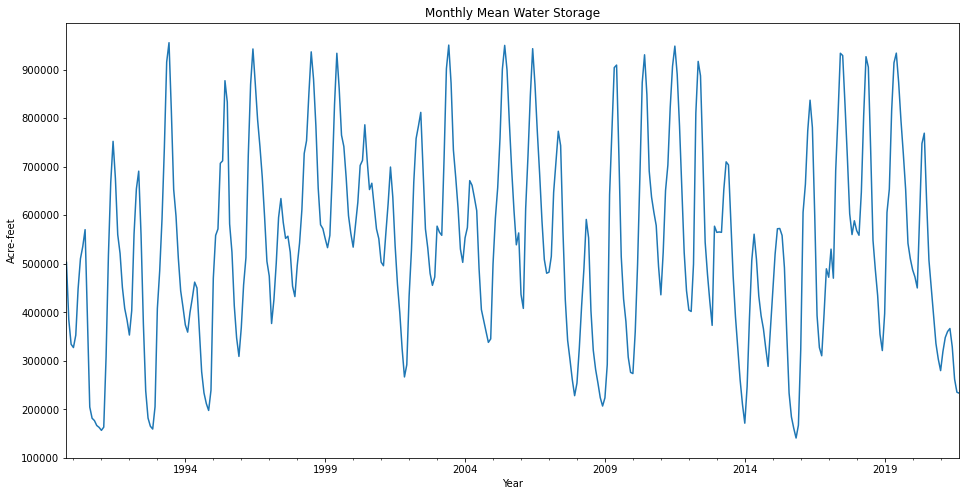

In [13]:
data.storage.plot(figsize=(16,8))
plt.xlabel('Year')
plt.ylabel('Acre-feet')
plt.title('Monthly Mean Water Storage')
plt.show();

Below, we can see that evaporation is high in the summers, especially in heat waves, and drops to near nothing in the winters. This is valuable for predicting water storage given its correlation to temperature nd its sizeable impact on reservoir levels.

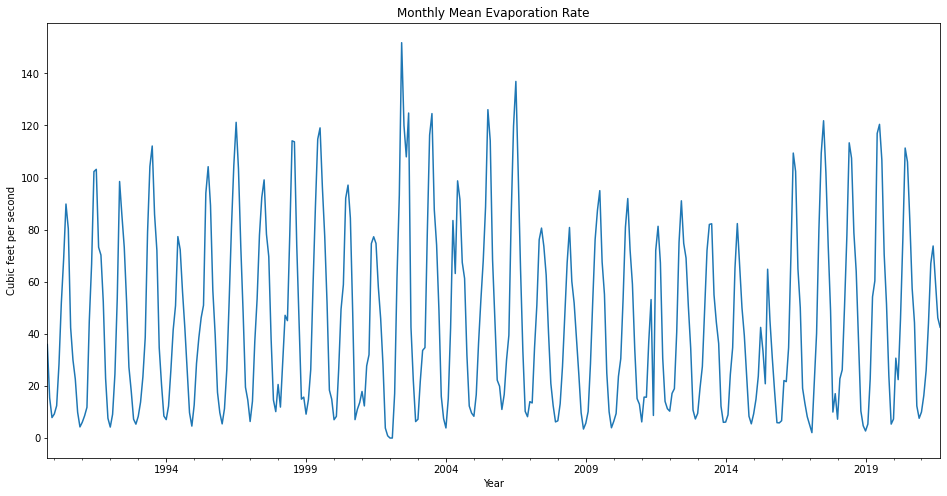

In [14]:
#plot average cfs evaporation per month

data.evaporation.plot(figsize=(16,8))
plt.xlabel('Year')
plt.ylabel('Cubic feet per second')
plt.title('Monthly Mean Evaporation Rate')
plt.show();

Below, we see how increasingly variable annual rainfall is. We can see its correlation to reservoir levels especially in the past couple years, 2019-2021, when a new drought began. The above reservoir storage also bottoms and doesn't recover.

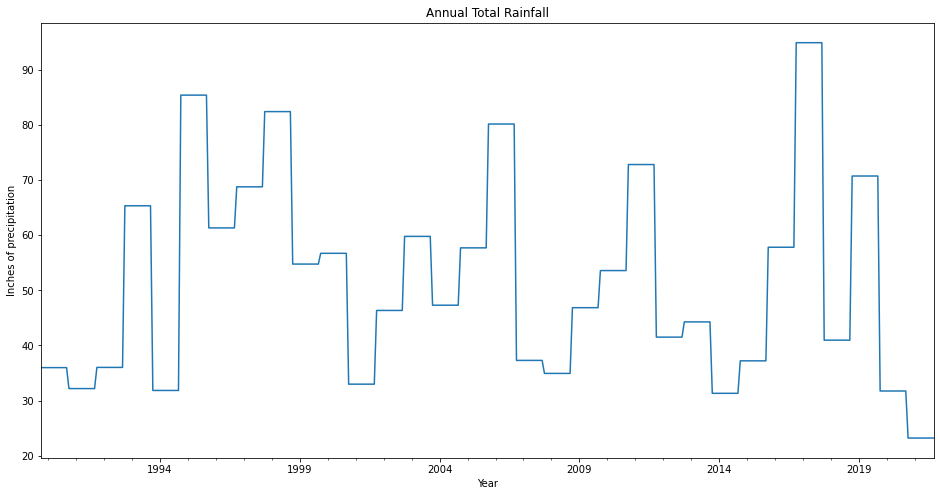

In [15]:
#plot annual rainfall

data.Annual.plot(figsize=(16,8))
plt.xlabel('Year')
plt.ylabel('Inches of precipitation')
plt.title('Annual Total Rainfall')
plt.show();

The below graph demonstrates the variability of California's climate but also affirms how important the winter rainfall season is. While varying in start date, winter is always the most time of rainfall.

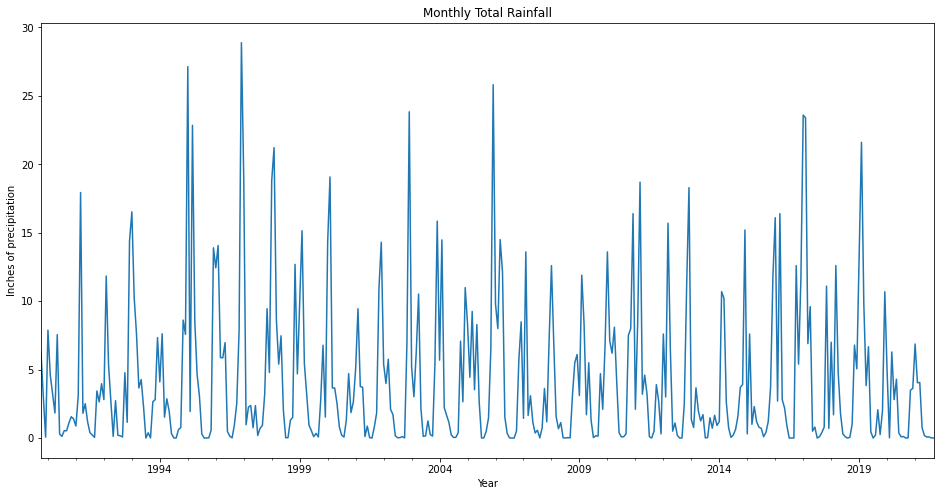

In [16]:
#plot monthly rainfall

data.Monthly.plot(figsize=(16,8))
plt.xlabel('Year')
plt.ylabel('Inches of precipitation')
plt.title('Monthly Total Rainfall')
plt.show();

### Examining the target's autocorrelation

Below, we see the strong seasonal correlation every 12 months. This correlation is significant even decades after measurement, shown by the fact the curve goes above the dotted line even past 250 months.

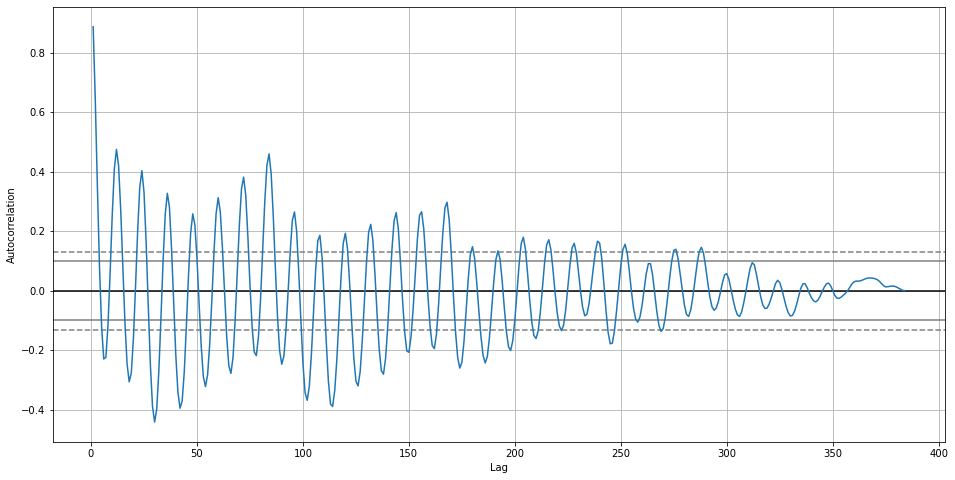

In [17]:
fig, ax1 = plt.subplots(figsize = (16,8))

pd.plotting.autocorrelation_plot(data['storage'],ax=ax1)
plt.show();

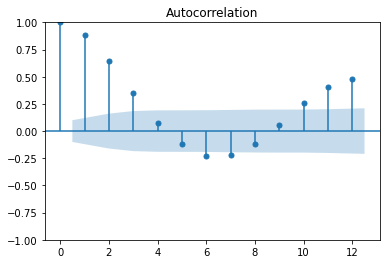

In [18]:
plot_acf(data['storage'],lags=12);

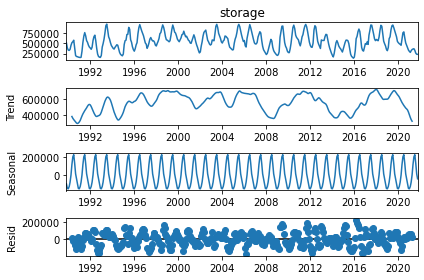

In [19]:
result = seasonal_decompose(pd.Series(data['storage']),model='additive', period=12)

result.plot()
plt.show();

The two lag plots below confirm that there is a positively linear correlation between the storage data a month and a year after. The y+1 is much stronger than the y+12.

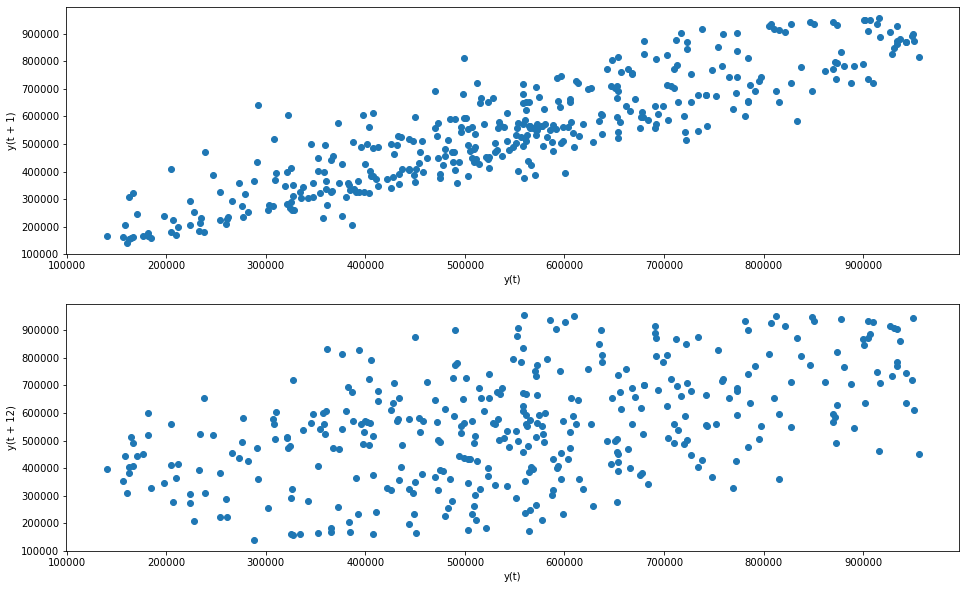

In [20]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(16,10))
pd.plotting.lag_plot(data['storage'],ax=ax1,lag=1)
pd.plotting.lag_plot(data['storage'],ax=ax2,lag=12)
plt.show();

## Testing for Stationarity

For modelling to be accurate, we need to test for stationarity. We will do this using the Augmented Dickey Fuller Test. The null hypothesis is that the data is non-stationary. 

In [21]:
result = adfuller(data['storage'])
result


(-4.429086309898389,
 0.0002635588358342595,
 12,
 371,
 {'1%': -3.4480996560263386,
  '5%': -2.8693621113224137,
  '10%': -2.570937038891028},
 9116.56569503065)

Because the p-value is .0007, we can confidently reject the null hypothesis. The data is therefore stationary.

# Modelling
Our goal is to find a model that can most accurately predict the 2020 water year reservoir storage based on past years data. To recap, water years run from October 1st to September 30th each year. We will test the value of using exogenous variables versus using an autoregressive, seasonal, and moving average model. 

As hinted above, I initially tried running a SARIMA model on daily data; but having 365 periods of data to run through per season was too computationally expensive. Thus we run all models like our data is, with 12 periods per season. 

## Creating the Train and Test Sets

To be able to make year ahead predictions, we can only use data from the past water year. So I must roll the exogenous variables forward so each water year's predictions are calculated on the past. This will make the 1990 water season not usable for the dataset when using exogenous variables, given we don't have 1989 WY data.

In [22]:
#roll exogenous variables 1 season behind
df = data.copy()

df['Last_Monthly_Prcp'] = data['Monthly'].shift(12)
df.drop('Monthly',axis=1,inplace=True)
df['Last_Annual_Prcp'] = data['Annual'].shift(12)
df.drop('Annual',axis=1,inplace=True)

df['Last_Monthly_Evap'] = data['evaporation'].shift(12)
df.drop('evaporation',axis=1,inplace=True)

df.head(15)
df = df['1990-10-01':'2020-10-01']

In [23]:
df.tail()

,storage,Last_Monthly_Prcp,Last_Annual_Prcp,Last_Monthly_Evap
date,,,,
2020-05-31,747746.10,6.67,70.72,60.35
2020-06-30,769089.07,0.46,70.72,116.93
2020-07-31,628340.87,0.00,70.72,120.42
2020-08-31,507140.26,0.21,70.72,106.74
2020-09-30,449203.07,2.07,70.72,70.47


In [24]:
#20 years of data to train
train_start, train_stop = '1990-10-01','2019-10-01'

#1 year for testing
test_start, test_stop = '2019-10-01', '2020-10-01'

#create train and 
train, test = df[train_start:train_stop], df[test_start:test_stop]

#create separate target and exogenous variable sets

X= df.drop('storage',axis=1,inplace=False)
y= df['storage']

X_train, X_test = X[train_start:train_stop], X[test_start:test_stop]
y_train, y_test = y[train_start:train_stop], y[test_start:test_stop]

print(test)

print(y_test)

              storage  Last_Monthly_Prcp  Last_Annual_Prcp  Last_Monthly_Evap
date                                                                         
2019-10-31  653416.03               1.02             70.72              37.74
2019-11-30  542141.93               6.79             70.72              10.37
2019-12-31  510450.68               5.06             70.72               4.71
2020-01-31  487421.52              13.18             70.72               2.71
2020-02-29  472678.55              21.61             70.72               5.36
2020-03-31  450046.26               9.82             70.72              22.65
2020-04-30  596788.93               3.83             70.72              54.20
2020-05-31  747746.10               6.67             70.72              60.35
2020-06-30  769089.07               0.46             70.72             116.93
2020-07-31  628340.87               0.00             70.72             120.42
2020-08-31  507140.26               0.21             70.72      

In [25]:
print(X.head())

            Last_Monthly_Prcp  Last_Annual_Prcp  Last_Monthly_Evap
date                                                              
1990-10-31               6.29             35.97              35.90
1990-11-30               3.08             35.97              15.41
1990-12-31               0.07             35.97               7.85
1991-01-31               7.88             35.97               9.24
1991-02-28               4.60             35.97              12.39


In [26]:
train.head()

,storage,Last_Monthly_Prcp,Last_Annual_Prcp,Last_Monthly_Evap
date,,,,
1990-10-31,176659.29,6.29,35.97,35.90
1990-11-30,166494.97,3.08,35.97,15.41
1990-12-31,162634.00,0.07,35.97,7.85
1991-01-31,156479.32,7.88,35.97,9.24
1991-02-28,163080.11,4.60,35.97,12.39


### Naive Model
The basic model predicts that the data is the same as last years, as the reservoir's ebb and flow is seasonal. So we use a lag of 12 months to predict the 2020 season.

In [27]:
#use test set copy for its datetime index
pred_naive = test.copy()

train_len = len(y_train)

#take the true values of the 2019 water year and input them as the naive prediction for the 2020 year
pred_naive.storage['2019-10-31':'2020-09-30'] = train.storage[train_len-12:train_len]

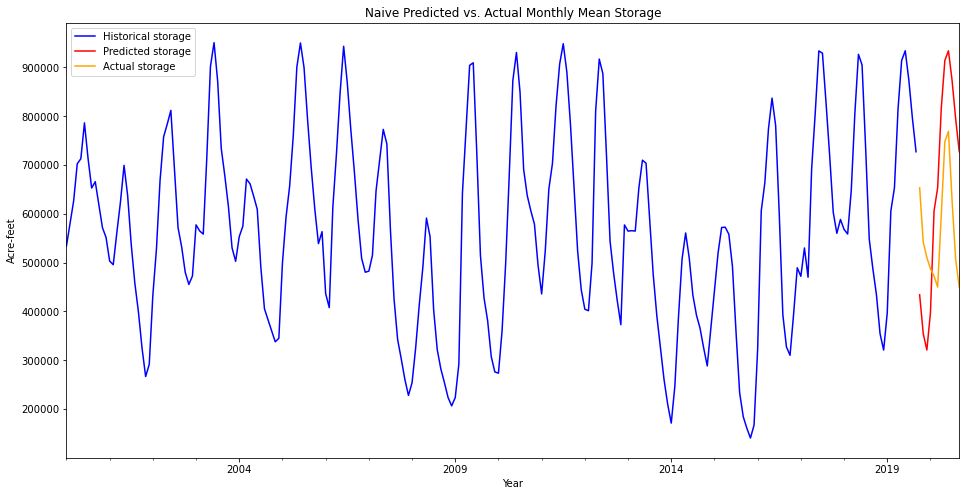

In [28]:
fig,ax = plt.subplots(figsize=(16,8))
train.storage['2000':].plot(ax=ax,color='blue',label = 'Historical storage')
pred_naive.storage.plot(ax=ax,color='red',label='Predicted storage')
test.storage.plot(ax=ax,color='orange',label='Actual storage')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Acre-feet')
plt.title('Naive Predicted vs. Actual Monthly Mean Storage')
plt.show();

From above, we can see the discrepency between predicted(red) and actual(orange). To formalize this, we can calculate RMSE and MAE to compare the improvement of models moving forwards.

In [29]:
rmse_naive = np.sqrt(mean_squared_error(pred_naive.storage,test.storage)).round(2) 
mae_naive = mean_absolute_error(pred_naive.storage,test.storage).round(2)
naive_cc = np.corrcoef(x=pred_naive.storage,y=test.storage)[0][1].round(4)
print('Naive model RMSE: ', rmse_naive, ' ; Naive model MAE', mae_naive, 
      ' ; Naive model Correlation Coefficient : ', naive_cc)

Naive model RMSE:  206099.11  ; Naive model MAE 198737.33  ; Naive model Correlation Coefficient :  0.4961


## SARIMA Model

In order to predict 12 months in advance, we can use lagged data in the SARIMA model. This model only uses past data of the storage levels, with a seasonal component. We use PMDArima's built in grid-search function to find the best paramaters for SARIMA. With the limitations, we find that a SARIMA model with p,d,q= (3,1,2) and P,D,Q= (0,1,1) is the strongest. We set the mode to 12 as the season is a year for monthly data, and limit the number of parameters to 10 in order to reduce computation time and overfitting.

### Training SARIMA

In [31]:
sarima_model = auto_arima(y_train,start_p=0,start_d=0,start_q=0,
          max_p=3,max_d=3,max_q=3, start_P=0,start_D=0,
          start_Q=0, max_P=3,max_D=3,
          max_Q=3, m=12, seasonal=True, max_order=10,
          error_action='warn',trace=True,
          supress_warnings=True,stepwise=False,
          random_state=20)

 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=9489.865, Time=0.01 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=9433.512, Time=0.05 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=9416.998, Time=0.17 sec
 ARIMA(0,0,0)(0,0,3)[12] intercept   : AIC=9387.777, Time=0.61 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=9482.613, Time=0.05 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=9418.805, Time=0.69 sec
 ARIMA(0,0,0)(1,0,3)[12] intercept   : AIC=9389.758, Time=2.31 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=9484.056, Time=0.56 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=1.04 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : AIC=inf, Time=0.88 sec
 ARIMA(0,0,0)(2,0,3)[12] intercept   : AIC=inf, Time=4.31 sec
 ARIMA(0,0,0)(3,0,0)[12] intercept   : AIC=9483.826, Time=2.57 sec
 ARIMA(0,0,0)(3,0,1)[12] intercept   : AIC=inf, Time=3.65 sec
 ARIMA(0,0,0)(3,0,2)[12] intercept   : AIC=9394.531, Time=4.70 sec
 ARIMA(0,0,0)(3,0,3)

/Users/jadeadams/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(0,0,2)(3,0,1)[12] intercept (if you do not want to see these warnings, run with error_action="ignore").
  warnings.warn(warning_str, ModelFitWarning)


 ARIMA(0,0,2)(3,0,1)[12] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,2)(3,0,2)[12] intercept   : AIC=9112.106, Time=5.33 sec
 ARIMA(0,0,2)(3,0,3)[12] intercept   : AIC=inf, Time=6.07 sec
 ARIMA(0,0,3)(0,0,0)[12] intercept   : AIC=9018.560, Time=0.04 sec
 ARIMA(0,0,3)(0,0,1)[12] intercept   : AIC=9013.591, Time=0.12 sec
 ARIMA(0,0,3)(0,0,2)[12] intercept   : AIC=9010.406, Time=0.43 sec
 ARIMA(0,0,3)(0,0,3)[12] intercept   : AIC=9009.837, Time=1.33 sec
 ARIMA(0,0,3)(1,0,0)[12] intercept   : AIC=9017.167, Time=0.26 sec
 ARIMA(0,0,3)(1,0,1)[12] intercept   : AIC=9015.189, Time=0.43 sec
 ARIMA(0,0,3)(1,0,2)[12] intercept   : AIC=9012.170, Time=1.53 sec
 ARIMA(0,0,3)(1,0,3)[12] intercept   : AIC=9011.757, Time=3.53 sec
 ARIMA(0,0,3)(2,0,0)[12] intercept   : AIC=9018.684, Time=1.57 sec
 ARIMA(0,0,3)(2,0,1)[12] intercept   : AIC=9011.696, Time=1.67 sec
 ARIMA(0,0,3)(2,0,2)[12] intercept   : AIC=9013.694, Time=2.17 sec
 ARIMA(0,0,3)(2,0,3)[12] intercept   : AIC=inf, Time=6.32 sec
 ARIMA(0,0,

 ARIMA(2,0,2)(2,0,2)[12] intercept   : AIC=8693.816, Time=2.19 sec
 ARIMA(2,0,2)(2,0,3)[12] intercept   : AIC=inf, Time=7.26 sec


/Users/jadeadams/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(2,0,2)(3,0,0)[12] intercept (if you do not want to see these warnings, run with error_action="ignore").
  warnings.warn(warning_str, ModelFitWarning)


 ARIMA(2,0,2)(3,0,0)[12] intercept   : AIC=inf, Time=nan sec
 ARIMA(2,0,2)(3,0,1)[12] intercept   : AIC=inf, Time=5.46 sec
 ARIMA(2,0,2)(3,0,2)[12] intercept   : AIC=inf, Time=5.51 sec
 ARIMA(2,0,2)(3,0,3)[12] intercept   : AIC=8671.154, Time=7.38 sec
 ARIMA(2,0,3)(0,0,0)[12] intercept   : AIC=8725.107, Time=0.11 sec
 ARIMA(2,0,3)(0,0,1)[12] intercept   : AIC=8708.457, Time=0.34 sec
 ARIMA(2,0,3)(0,0,2)[12] intercept   : AIC=8688.208, Time=1.15 sec
 ARIMA(2,0,3)(0,0,3)[12] intercept   : AIC=8683.159, Time=3.77 sec
 ARIMA(2,0,3)(1,0,0)[12] intercept   : AIC=8699.482, Time=0.66 sec
 ARIMA(2,0,3)(1,0,1)[12] intercept   : AIC=8681.735, Time=0.69 sec
 ARIMA(2,0,3)(1,0,2)[12] intercept   : AIC=8673.400, Time=2.24 sec
 ARIMA(2,0,3)(1,0,3)[12] intercept   : AIC=8674.368, Time=5.23 sec
 ARIMA(2,0,3)(2,0,0)[12] intercept   : AIC=8672.106, Time=2.20 sec
 ARIMA(2,0,3)(2,0,1)[12] intercept   : AIC=8669.438, Time=2.59 sec
 ARIMA(2,0,3)(2,0,2)[12] intercept   : AIC=8669.924, Time=3.23 sec
 ARIMA(2,0,

/Users/jadeadams/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(3,0,1)(3,0,0)[12] intercept (if you do not want to see these warnings, run with error_action="ignore").
  warnings.warn(warning_str, ModelFitWarning)


 ARIMA(3,0,1)(3,0,0)[12] intercept   : AIC=inf, Time=nan sec
 ARIMA(3,0,1)(3,0,1)[12] intercept   : AIC=inf, Time=7.52 sec
 ARIMA(3,0,1)(3,0,2)[12] intercept   : AIC=inf, Time=7.86 sec
 ARIMA(3,0,1)(3,0,3)[12] intercept   : AIC=inf, Time=7.73 sec
 ARIMA(3,0,2)(0,0,0)[12] intercept   : AIC=8723.097, Time=0.09 sec
 ARIMA(3,0,2)(0,0,1)[12] intercept   : AIC=8708.747, Time=0.32 sec
 ARIMA(3,0,2)(0,0,2)[12] intercept   : AIC=8689.595, Time=1.03 sec
 ARIMA(3,0,2)(0,0,3)[12] intercept   : AIC=8684.786, Time=3.09 sec
 ARIMA(3,0,2)(1,0,0)[12] intercept   : AIC=8697.155, Time=0.65 sec
 ARIMA(3,0,2)(1,0,1)[12] intercept   : AIC=8692.314, Time=0.90 sec
 ARIMA(3,0,2)(1,0,2)[12] intercept   : AIC=8681.341, Time=2.95 sec
 ARIMA(3,0,2)(1,0,3)[12] intercept   : AIC=8681.309, Time=6.76 sec
 ARIMA(3,0,2)(2,0,0)[12] intercept   : AIC=inf, Time=2.57 sec
 ARIMA(3,0,2)(2,0,1)[12] intercept   : AIC=8677.914, Time=2.79 sec
 ARIMA(3,0,2)(2,0,2)[12] intercept   : AIC=8679.683, Time=2.79 sec
 ARIMA(3,0,2)(2,0,3)[

In [34]:
sarima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                             storage   No. Observations:                  348
Model:             SARIMAX(3, 0, 3)x(3, 0, [], 12)   Log Likelihood              -19939.008
Date:                             Wed, 08 Dec 2021   AIC                          39898.016
Time:                                     18:04:59   BIC                          39936.538
Sample:                                 10-31-1990   HQIC                         39913.352
                                      - 09-30-2019                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8989      0.103     18.444      0.000       1.697       2.101
ar.L2         -1.0371      0.206     -5.027      0.000      -1.441      -0.633
ar.L3          0.1217      0.107      1.142      0.254      -0.087       0.331
ma.L1         -0.5953      0.117     -5.087      0.000      -0.825      -0.366
ma.L2         -0.3302      0.088     -3.742      0.000      -0.503      -0.157
ma.L3         -0.1149      0.071     -1.613      0.107      -0.255       0.025
ar.S.L12       0.3175      0.061      5.240      0.000       0.199       0.436
ar.S.L24       0.4364      0.056      7.801      0.000       0.327       0.546
ar.S.L36       0.2416      0.060      4.017      0.000       0.124       0.360
sigma2      4.336e+09   1.92e-11   2.25e+20      0.000    4.34e+09    4.34e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):           1660281.64
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               0.00   Skew:                            18.31
Prob(H) (two-sided):                  0.00   Kurtosis:                       339.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.46e+36. Standard errors may be unstable.
"""

Non-step-wise grid searches are time intensive but result in the best possible data fit. I will use these grid-searched paramaters for testing Folsom Lake. Later, I decide to use these paramaters successfully work as the best fit for all the other reservoirs too. 

### Testing SARIMA

/Users/jadeadams/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/jadeadams/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/jadeadams/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/jadeadams/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maxi

storage              mean        mean_se  mean_ci_lower  mean_ci_upper
2019-10-31  612707.140423   67572.687249  480267.107076   7.451472e+05
2019-11-30  531481.262619  113817.696251  308402.677164   7.545598e+05
2019-12-31  504681.960721  140885.863697  228550.741944   7.808132e+05
2020-01-31  475470.694429  154551.384965  172555.546136   7.783858e+05
2020-02-29  521074.941308  161165.269471  205196.817586   8.369531e+05
2020-03-31  538302.804212  164116.859435  216639.670464   8.599659e+05
2020-04-30  696452.207504  165234.299264  372598.931935   1.020305e+06
2020-05-31  798490.770423  165528.094258  474061.667247   1.122920e+06
2020-06-30  820040.222814  165548.449830  495571.223450   1.144509e+06
2020-07-31  722578.558724  165574.878765  398057.759600   1.047099e+06
2020-08-31  591708.520430  165727.444512  266888.697937   9.165283e+05
2020-09-30  519692.828396  166035.922900  194268.399371   8.451173e+05


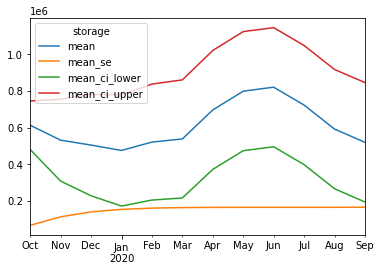

In [33]:
#fit model

sarima_model = SARIMAX(endog= y_train,order=(3,0,3),seasonal_order=(3,0,0,12),enforce_invertibility=False,initialization='approximate_diffuse').fit()

#forecast ahead 1 year
sarima_preds = sarima_model.get_forecast(steps=12)
print(sarima_preds.summary_frame())
sarima_preds.summary_frame().plot()
plt.show();

In [35]:
sarima_model.aic

39898.01565069128

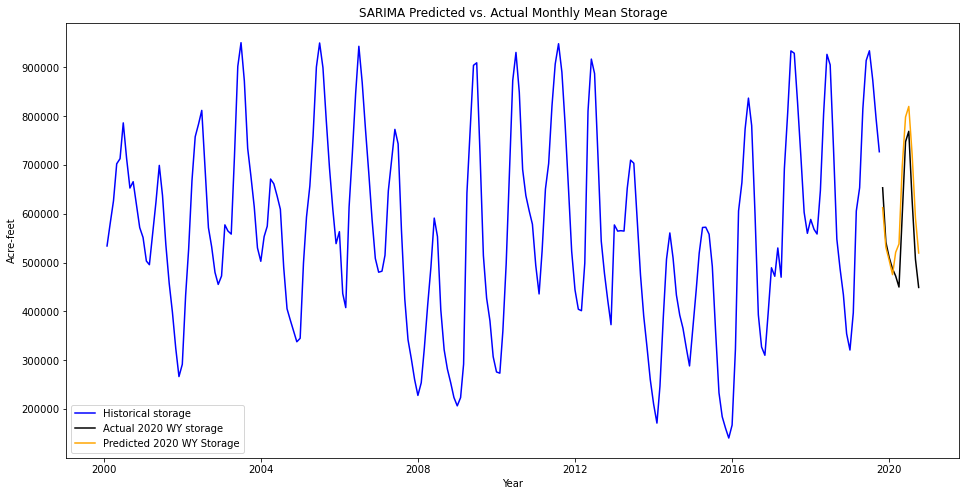

In [36]:
fig,ax = plt.subplots(figsize=(16,8))
ax.plot(y_train['2000':], color = 'blue',label= 'Historical storage')
ax.plot(test.storage,color='black',label= 'Actual 2020 WY storage')
ax.plot(sarima_preds.summary_frame()['mean'],color= 'orange', label= 'Predicted 2020 WY Storage')

plt.legend()
plt.xlabel('Year')
plt.ylabel('Acre-feet')
plt.title('SARIMA Predicted vs. Actual Monthly Mean Storage')
plt.show();

In [37]:
rmse_sarima = np.sqrt(mean_squared_error(sarima_preds.summary_frame()['mean'],test.storage)).round(2) 
mae_sarima = mean_absolute_error(sarima_preds.summary_frame()['mean'],test.storage).round(2)
sarima_cc = np.corrcoef(x=sarima_preds.summary_frame()['mean'],y=test.storage)[0][1].round(4)

print('SARIMA model RMSE: ', rmse_sarima, ' ; SARIMA model MAE', mae_sarima,
     'SARIMA correlation coefficient',sarima_cc)

error_reduction = 1 - (mae_sarima/mae_naive)

print('Error reduced by: ', error_reduction,'%')

SARIMA model RMSE:  63366.36  ; SARIMA model MAE 54699.74 SARIMA correlation coefficient 0.9141
Error reduced by:  0.7247636365045258 %


In [38]:
np.mean(test.storage)

567871.9391666667

By the mean absolute error above, we can see a clear improvement of a SARIMA forecast, to the tune of reducing error by 72.5%. The relative movement of the prediction is much more similar to the actual as well, the correlation coefficient increased to .92 from .54.

## SARIMAX: Incorporating exogenous models

Our goal is to now see if incorporating the precipitation and evaporation data improves the prediction. We will first  run the gridsearched paramaters with exogenous variables, then we will gridsearch with the exogenous variables to see if the paramaters change. 

We have to set up our own model grid search as no library contains the functionality to compare time series models with exogenous paramaters. Below, I set up grid search functions and then run it to find the best paramaters.

### Modelling

I took inspiration from the papers I read on natural time series. I iterated through SARIMA, SARIMAX, and an HWES, finding the best parameters through AIC-scoring in order to prevent data leakage. 

### Testing

I then compared the performance of the models on the test set, using RMSE, CC, and NSE as parameters. Each has their own unique strength.

## First SARIMAX Model

I fit and test the p,d,q= (3,0,3) and P,D,Q= (3,0,0) with the exogenous variables below.

/Users/jadeadams/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/jadeadams/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


storage              mean        mean_se  mean_ci_lower  mean_ci_upper
2019-10-31  318348.112972  153383.519153   17721.939610   6.189743e+05
2019-11-30  529284.223178  230309.949788   77885.016313   9.806834e+05
2019-12-31  503482.218721  305186.992984  -94673.296079   1.101638e+06
2020-01-31  401332.150974  350430.845718 -285499.685706   1.088164e+06
2020-02-29  304212.029516  403822.001567 -487264.549720   1.095689e+06
2020-03-31  334644.068758  439195.002253 -526162.317847   1.195450e+06
2020-04-30  527553.356364  483060.597501 -419228.017088   1.474335e+06
2020-05-31  698685.109566  513162.549291 -307095.005259   1.704465e+06
2020-06-30  736987.142551  551349.986939 -343638.974726   1.817613e+06
2020-07-31  652166.309319  578060.675943 -480811.796408   1.785144e+06
2020-08-31  423136.473030  612382.006527 -777110.204545   1.623383e+06
2020-09-30  356851.767907  636685.943198 -891029.750224   1.604733e+06


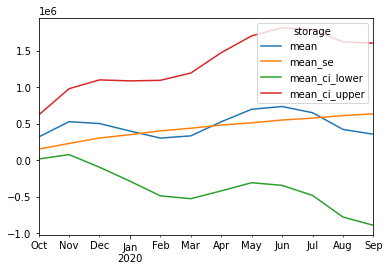

In [39]:
#fit and train

sarimax1_model = SARIMAX(endog= y_train,exog=X_train, order=(3,0,3),seasonal_order=(3,0,0,12),enforce_invertibility=False,initialization='approximate_diffuse').fit()

#predict 1 year
sarimax1_preds = sarimax1_model.get_forecast(steps=12,exog=X_test)
print(sarimax1_preds.summary_frame())
sarimax1_preds.summary_frame().plot()
plt.show();

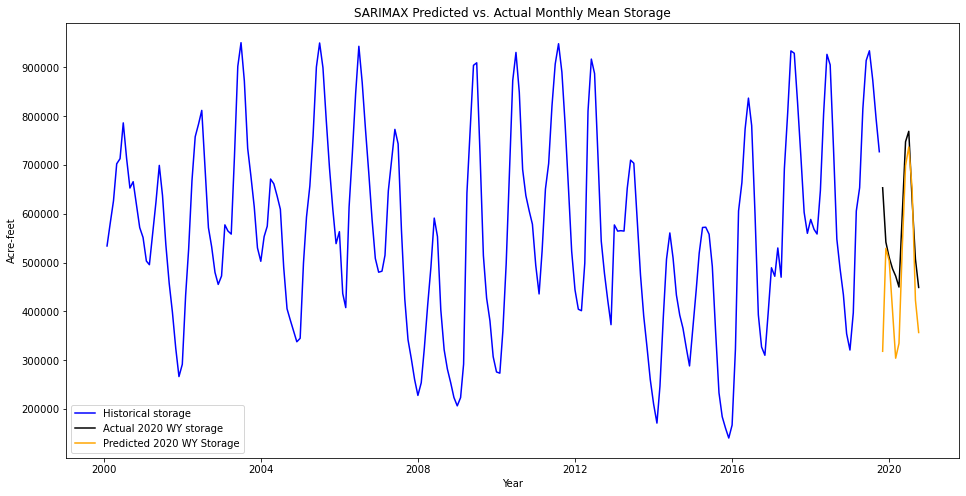

In [40]:
fig,ax = plt.subplots(figsize=(16,8))
ax.plot(y_train['2000':], color = 'blue',label= 'Historical storage')
ax.plot(test.storage,color='black',label= 'Actual 2020 WY storage')
ax.plot(sarimax1_preds.summary_frame()['mean'],color= 'orange', label= 'Predicted 2020 WY Storage')

plt.legend()
plt.xlabel('Year')
plt.ylabel('Acre-feet')
plt.title('SARIMAX Predicted vs. Actual Monthly Mean Storage')
plt.show();

In [41]:
rmse_sarimax1 = np.sqrt(mean_squared_error(sarimax1_preds.summary_frame()['mean'],test.storage)).round(2) 
mae_sarimax1 = mean_absolute_error(sarimax1_preds.summary_frame()['mean'],test.storage).round(2)
sarimax1_cc = np.corrcoef(x=sarimax1_preds.summary_frame()['mean'],y=test.storage)[0][1].round(4)

print('First SARIMAX model RMSE: ', rmse_sarimax1, ' ; First SARIMAX model MAE', mae_sarimax1,
     'First SARIMAX model CC:', sarimax1_cc)

error_reduction = 1 - (mae_sarimax1/mae_naive)

print('Error reduced by: ', error_reduction,'%')

First SARIMAX model RMSE:  124491.81  ; First SARIMAX model MAE 89619.27 First SARIMAX model CC: 0.7828
Error reduced by:  0.549056687035093 %


Using the exogenous paramaters with the gridsearched SARIMA parameters is less accurate prediction than the MAE. The relative movement is also less similar, the correlation coefficient dropped to .78. This is visible in the graph above too, where the orange line's movement for the first couple months opposes the actual.

## Gridsearched SARIMAX

In [ ]:
#set up gridsearch

#pdq are the ARMA potential paramaters
p = d = q = range(0,4)

arma_param_options = list(itertools.product(p,d,q))
print(arma_param_options)


#creating pdq for the seasonal potential paramaters, 12 for the seasonal gap
seasonal_param_options = [(x[0],x[1],x[2],12) for x in arma_param_options]
seasonal_param_options

In [ ]:
#gridsearch function

iteration = 0

for pdq in arma_param_options:
    for PDQ in seasonal_param_options:
        sarimax_gs = SARIMAX(endog= y_train,exog=X_train, order=pdq,seasonal_order=PDQ,enforce_invertibility=False,initialization='approximate_diffuse').fit()
        aic = sarimax_gs.aic
        if iteration ==0:
            best_fit = [pdq,PDQ, aic]
            print(best_fit[2])
        elif best_fit[2] > aic:
            best_fit = [pdq,PDQ,aic]
            print(best_fit)
        iteration += 1

return (best_fit)


After running this non-parallelized grid search overnight, I was able to determine that the best set of paramaters is (p,d,q)=(2,0,1) and (P,D,Q,s)=(3,0,0,12). With more time for this project, I would've created my own stepwise gridsearch as it would've been a lot less computationally intensive.

In [42]:
best_fit = [(2,0,1),(3,0,0,12),8766]

best_sarimax = SARIMAX(endog=y_train,exog=X_train,order = best_fit[0],seasonal_order=best_fit[1]).fit()
best_sarimax.summary()

/Users/jadeadams/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/jadeadams/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                             storage   No. Observations:                  348
Model:             SARIMAX(2, 0, 1)x(3, 0, [], 12)   Log Likelihood               -4486.742
Date:                             Wed, 08 Dec 2021   AIC                           8993.484
Time:                                     18:05:38   BIC                           9032.006
Sample:                                 10-31-1990   HQIC                          9008.820
                                      - 09-30-2019                                         
Covariance Type:                               opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Last_Monthly_Prcp  6242.5566    835.693      7.470      0.000    4604.628    7880.486
Last_Annual_Prcp   5730.3117    378.341     15.146      0.000    4988.777    6471.846
Last_Monthly_Evap  4487.5389    251.816     17.821      0.000    3993.989    4981.088
ar.L1                 1.5203      0.148     10.264      0.000       1.230       1.811
ar.L2                -0.6458      0.119     -5.437      0.000      -0.879      -0.413
ma.L1                -0.5393      0.173     -3.114      0.002      -0.879      -0.200
ar.S.L12             -0.1198      0.063     -1.903      0.057      -0.243       0.004
ar.S.L24              0.2382      0.063      3.797      0.000       0.115       0.361
ar.S.L36              0.1198      0.073      1.644      0.100      -0.023       0.263
sigma2             9.981e+09      0.000   2.81e+13      0.000    9.98e+09    9.98e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                10.59
Prob(Q):                              0.98   Prob(JB):                         0.01
Heteroskedasticity (H):               1.32   Skew:                            -0.07
Prob(H) (two-sided):                  0.14   Kurtosis:                         3.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.6e+27. Standard errors may be unstable.
"""

### Testing the Grid-Searched SARIMAX

storage              mean        mean_se  mean_ci_lower  mean_ci_upper
2019-10-31  638284.092559   99904.196129  442475.466242   8.340927e+05
2019-11-30  538100.150927  139951.354893  263800.535750   8.123998e+05
2019-12-31  482309.053277  163473.394845  161907.086950   8.027110e+05
2020-01-31  467049.599202  175974.716994  122145.491704   8.119537e+05
2020-02-29  505154.730568  181508.237873  149405.121439   8.609043e+05
2020-03-31  512227.601331  183297.253275  152971.586447   8.714836e+05
2020-04-30  642695.990003  183576.136696  282893.373658   1.002499e+06
2020-05-31  682949.940968  183579.558818  323140.617387   1.042759e+06
2020-06-30  873899.726285  183764.251385  513728.411925   1.234071e+06
2020-07-31  845123.134959  184142.636196  484210.199996   1.206036e+06
2020-08-31  767734.226461  184574.458208  405974.935906   1.129494e+06
2020-09-30  631057.212907  184936.343006  268588.641183   9.935258e+05


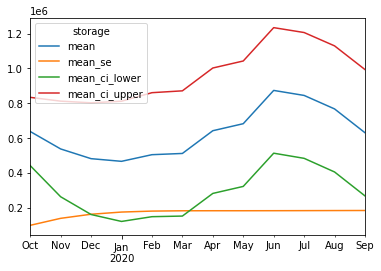

In [43]:
#predict 1 year
best_sarimax_preds = best_sarimax.get_forecast(steps=12,exog=X_test)
print(best_sarimax_preds.summary_frame())
best_sarimax_preds.summary_frame().plot()
plt.show();

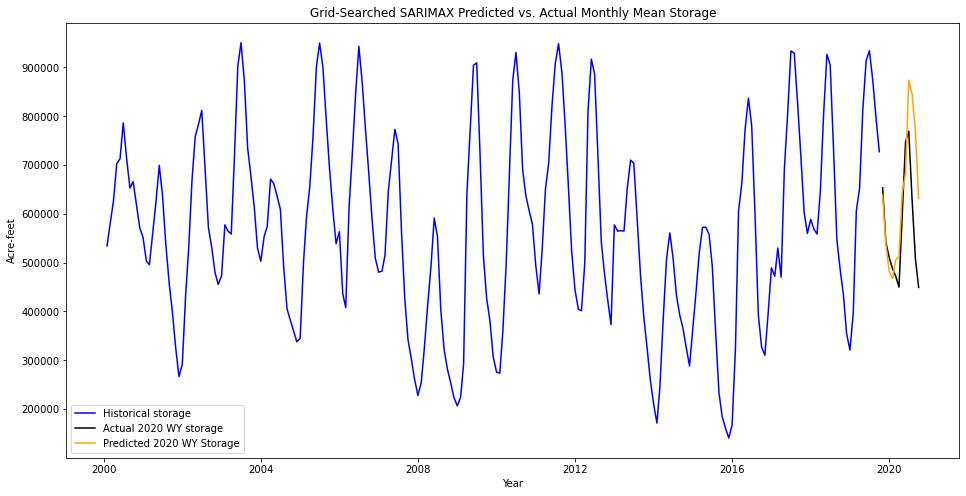

In [44]:
fig,ax = plt.subplots(figsize=(16,8))
ax.plot(y_train['2000':], color = 'blue',label= 'Historical storage')
ax.plot(test.storage,color='black',label= 'Actual 2020 WY storage')
ax.plot(best_sarimax_preds.summary_frame()['mean'],color= 'orange', label= 'Predicted 2020 WY Storage')

plt.legend()
plt.xlabel('Year')
plt.ylabel('Acre-feet')
plt.title('Grid-Searched SARIMAX Predicted vs. Actual Monthly Mean Storage')
plt.show();

In [45]:
rmse_sarimax_best = np.sqrt(mean_squared_error(best_sarimax_preds.summary_frame()['mean'],test.storage)).round(2) 
mae_sarimax_best = mean_absolute_error(best_sarimax_preds.summary_frame()['mean'],test.storage).round(2)
best_sarimax_cc = np.corrcoef(x=best_sarimax_preds.summary_frame()['mean'],y=test.storage)[0][1].round(4)

print('Grid Searched SARIMAX model RMSE: ', rmse_sarimax_best, ' ; Grid Searched SARIMAX model MAE', mae_sarimax_best,
     'Grid Searched SARIMAX CC: ', best_sarimax_cc)

error_reduction = 1 - (mae_sarimax_best/mae_naive)

print('Error reduced by: ', error_reduction,'%')

Grid Searched SARIMAX model RMSE:  119596.36  ; Grid Searched SARIMAX model MAE 86424.09 Grid Searched SARIMAX CC:  0.6682
Error reduced by:  0.5651340893026993 %


Grid searching only reduced the error terms compared to the naive by 2%, and it decreased the relative similarity in movement, the CC dropped from .78 to .67. We can see this in the graph above given the discrepancies in slope between actual and prediction. The model with exogenous variables is still significantly weaker than the pure SARIMA model.

## Exponential Smoothing

Below, I demonstrate the importance of selecting models that do not implement trends, with seasonal, controlled data like a reservoir. Exponential Smoothing requires an increasing or decreasing trend in either the seasonal amplitude or the overall values. We can observe a clear issue in modelling, where the model goes into an impossible range, above the capacity of Folsom Lake. 

In [46]:
hwes = HWES(endog=y_train,seasonal_periods=12,seasonal='add').fit()

hwes.summary()

/Users/jadeadams/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
/Users/jadeadams/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Dep. Variable:,storage,No. Observations:,348
Model:,ExponentialSmoothing,SSE,1459185243234.639
Optimized:,True,AIC,7738.531
Trend:,None,BIC,7792.461
Seasonal:,Additive,AICC,7740.174
Seasonal Periods:,12,Date:,"Wed, 08 Dec 2021"
Box-Cox:,False,Time:,18:05:54
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9714286,alpha,True
smoothing_seasonal,0.0285714,gamma,True


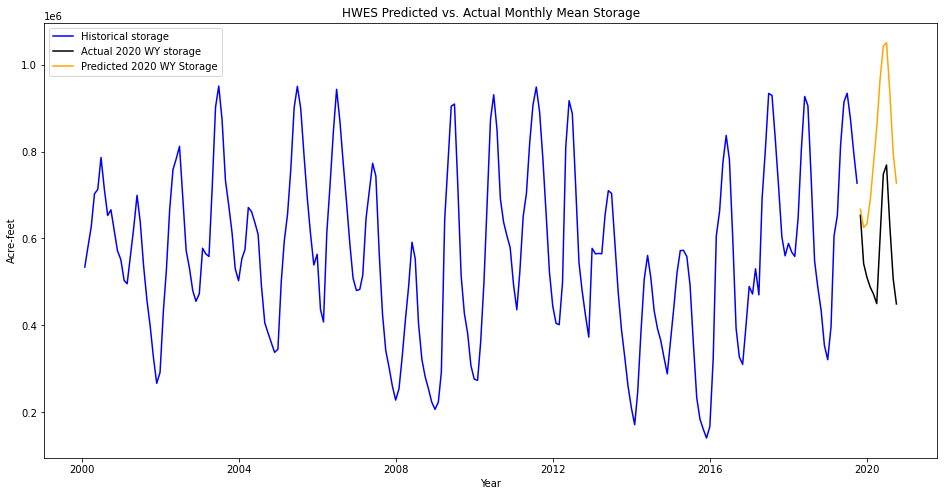

In [47]:
hwes_preds = hwes.forecast(12)
fig,ax = plt.subplots(figsize=(16,8))
ax.plot(y_train['2000':], color = 'blue',label= 'Historical storage')
ax.plot(test.storage,color='black',label= 'Actual 2020 WY storage')
ax.plot(hwes_preds,color= 'orange', label= 'Predicted 2020 WY Storage')

plt.legend()
plt.xlabel('Year')
plt.ylabel('Acre-feet')
plt.title('HWES Predicted vs. Actual Monthly Mean Storage')
plt.show();

In [48]:
rmse_hwes = np.sqrt(mean_squared_error(hwes_preds,test.storage)).round(2) 
mae_hwes = mean_absolute_error(hwes_preds,test.storage).round(2)
cc_hwes = np.corrcoef(x=hwes_preds,y=test.storage)[0][1].round(4)

print('Grid Searched SARIMAX model RMSE: ', rmse_hwes, ' ; Grid Searched SARIMAX model MAE', mae_hwes,
     'Grid Searched SARIMAX CC: ', cc_hwes)

error_reduction = 1 - (mae_sarimax_best/mae_naive)

print('Error reduced by: ', error_reduction,'%')

Grid Searched SARIMAX model RMSE:  269407.45  ; Grid Searched SARIMAX model MAE 245061.52 Grid Searched SARIMAX CC:  0.6562
Error reduced by:  0.5651340893026993 %


## Model Comparison

The best model was clearly the SARIMA model. It had the lowest errors and the highest correlation, meaning it tracked the most with the actual ebb and flow of the reservoir. Overall, the MAE was reduced by 78% compared to a naive model, the mean error was within an average of 9.5% of the actual value, and the correlation coefficent was high, .92, meaning that it matched 92% of the ebb and flow of the reservoir.

## Future Prediction: The 2021 season at Folsom Lake

To ensure accuracy, I wanted to test the model on Folsom Lake in an abnormal year, the dry 2021 water year which recently ended. As the drought has intensified, the water level has dipped to a 5 year low. We see below how the fitted paramters handle the data. I adjust the train set to run from 1989 through 2020.

In [66]:
#20 years of data to train
train_start, train_stop = '1990-10-01','2020-10-01'

#1 year for testing
test_start, test_stop = '2020-10-01', '2021-10-01'

#create train and 
train, test = storage[train_start:train_stop], storage[test_start:test_stop]

/Users/jadeadams/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/jadeadams/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


storage              mean        mean_se  mean_ci_lower  mean_ci_upper
2020-10-31  391566.447129   66662.424365  260910.496251   5.222224e+05
2020-11-30  320307.448974  112643.459172   99530.325903   5.410846e+05
2020-12-31  310199.573057  143320.126382   29297.287088   5.911019e+05
2021-01-31  345509.283686  159904.852066   32101.532684   6.589170e+05
2021-02-28  448947.382625  168615.452630  118467.168234   7.794276e+05
2021-03-31  493003.827800  172911.726692  154103.070980   8.319046e+05
2021-04-30  657063.570787  174769.092101  314522.444658   9.996047e+05
2021-05-31  784537.736760  175379.796525  440799.651956   1.128276e+06
2021-06-30  804741.318633  175473.061769  460820.437309   1.148662e+06
2021-07-31  705926.800961  175479.594434  361993.115848   1.049860e+06
2021-08-31  600440.883077  175630.209359  256211.998136   9.446698e+05
2021-09-30  544634.837699  176022.792784  199636.503384   8.896332e+05


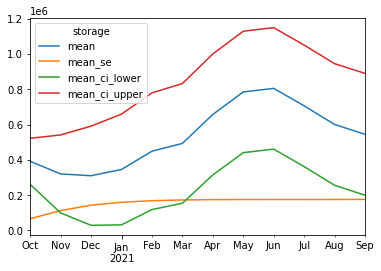

In [67]:
fl_model_2021 = SARIMAX(endog= train.storage,order=(3,0,3),seasonal_order=(3,0,0,12),enforce_invertibility=False,initialization='approximate_diffuse').fit()

#forecast ahead 1 year
fl_preds_2021 = fl_model_2021.get_forecast(steps=12)
print(fl_preds_2021.summary_frame())
fl_preds_2021.summary_frame().plot()
plt.show();


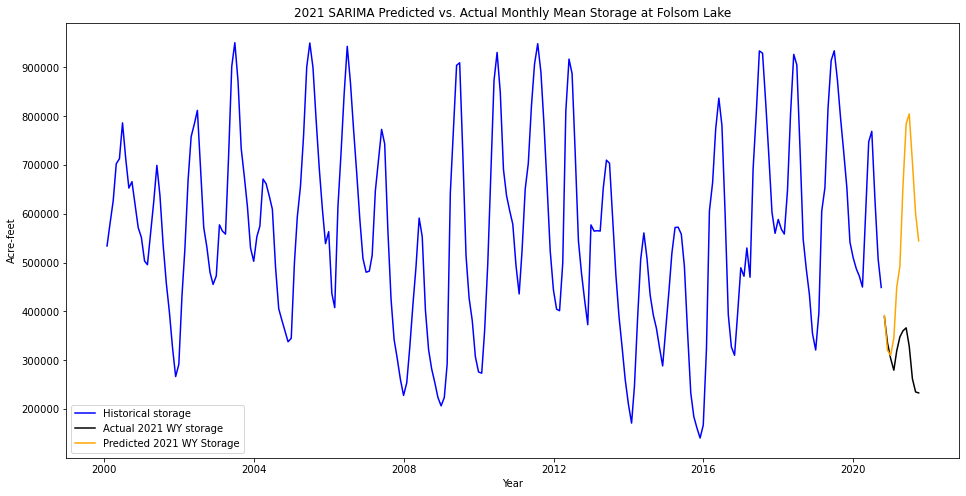

In [68]:
fig,ax = plt.subplots(figsize=(16,8))
ax.plot(train.storage['2000':], color = 'blue',label= 'Historical storage')
ax.plot(test['storage'],color='black',label= 'Actual 2021 WY storage')
ax.plot(fl_preds_2021.summary_frame()['mean'],color= 'orange', label= 'Predicted 2021 WY Storage')

plt.legend()
plt.xlabel('Year')
plt.ylabel('Acre-feet')
plt.title('2021 SARIMA Predicted vs. Actual Monthly Mean Storage at Folsom Lake')
plt.show();

In [70]:
rmse_2021 = np.sqrt(mean_squared_error(hwes_preds,test.storage)).round(2) 
mae_2021 = mean_absolute_error(hwes_preds,test.storage).round(2)
cc_2021 = np.corrcoef(x=hwes_preds,y=test.storage)[0][1].round(4)

print('Grid Searched SARIMAX model RMSE: ', rmse_2021, ' ; Grid Searched SARIMAX model MAE', mae_2021,
     'Grid Searched SARIMAX CC: ', cc_2021)

error_reduction = 1 - (mae_2021/mae_naive)

print('Error reduced by: ', error_reduction,'%')

Grid Searched SARIMAX model RMSE:  520639.03  ; Grid Searched SARIMAX model MAE 499594.18 Grid Searched SARIMAX CC:  0.192
Error reduced by:  -1.5138416622584194 %


We can conclude that the seasonal prediction model works a lot better for more normal years, where the past year was not an exceptional drought. It is impossible for models to pick up precipitous drops in rainfall a year in advance, even if they can detect from current reservoir stress there will be a decline. In fact, this was the only case so far where a model was worse than a naive model.

# Expanding the Model to Other Dams in California

Now that we have found that SARIMA is clearly the strongest on predicting reservoir storage, we will expand it out to other major California dams to see if it performs as well. Exogenous variables with a 1 year time delay have proven to be imperfect at reservoir prediction. I predicted that given the similarities in water requirements for agriculture and the similarity in the rain season.

To recap, we will only be using the endogenous y_train and y_test. The test season is the 2020 water year.

## Data Preparation

We will load and prepare the lake storage datasets from the RISE query website with the following function:

In [12]:
def rise_data_prep(df):
    #drop unneeded cols
    drop_list = ['Location','Parameter','Timestep','Units','Aggregation']
    df.drop(drop_list, axis=1,inplace=True)
    df.rename(columns= {'Result': 'storage'},inplace=True)
    #set index to datetime
    df['date']= pd.to_datetime(df['Datetime (UTC)']).dt.date
    df.drop('Datetime (UTC)',axis=1,inplace=True)
    df.set_index('date',inplace=True)
    df.index = pd.to_datetime(df.index)
    
    #group up monthly
    df = df.storage.resample('1M').mean().round(2)
    df = df.to_frame()
    return(df)

def cdec_data_prep(df):
    #drop unneeded cols
    drop_list = ['STATION_ID','DURATION','SENSOR_NUMBER','SENS_TYPE','DATA_FLAG','UNITS','DATE TIME']
    df.drop(drop_list, axis=1,inplace=True)
    df.rename(columns= {'VALUE': 'storage'},inplace=True)
    #set index to datetime
    df['date'] = df['OBS DATE'].apply(lambda x: pd.to_datetime(str(x),format='%Y%m%d'))
    #df['date']= pd.to_datetime(df['OBS DATE']).dt.date
    df.drop('OBS DATE',axis=1,inplace=True)
    df.set_index('date',inplace=True)
    df.index = pd.to_datetime(df.index)
    
    #group up monthly
    df.storage = df.storage.replace(',','', regex=True)
    df.storage = pd.to_numeric(df.storage)
    df = df.resample('1M').mean().round(2)
    df.storage = df.storage.astype('float64')
    return(df)

#get name for plots
def get_lake_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

In [13]:
#load all the lakes
#cdec queried
oroville = pd.read_excel('data/otherlakes/ORO_15.xlsx')
mcclure = pd.read_excel('data/otherlakes/EXC_15.xlsx')
donpedro = pd.read_excel('data/otherlakes/DNP_15.xlsx')
pineflat = pd.read_excel('data/otherlakes/PNF_15.xlsx')

#rise queried
trinity = pd.read_csv('data/otherlakes/trinitylake.csv', header= 7)
newmelones = pd.read_csv('data/otherlakes/newmelones.csv', header= 7)
millerton = pd.read_csv('data/otherlakes/millertonlake.csv', header= 7)
berryessa = pd.read_csv('data/otherlakes/shastalake.csv', header= 7)
shasta = pd.read_csv('data/otherlakes/lakeberryessa.csv', header= 7)



shasta = rise_data_prep(shasta)
trinity = rise_data_prep(trinity)
newmelones = rise_data_prep(newmelones)
berryessa = rise_data_prep(berryessa)
millerton = rise_data_prep(millerton)

oroville = cdec_data_prep(oroville)
mcclure = cdec_data_prep(mcclure)
donpedro = cdec_data_prep(donpedro)
pineflat = cdec_data_prep(pineflat)



rise_lake_dfs = [trinity,newmelones,millerton,berryessa,shasta]
cdec_lake_dfs = [oroville,mcclure,donpedro,pineflat]

## Exploratory Data Analysis

A cycle through of all the lakes to see if they also function seasonally like Lake Folsom.

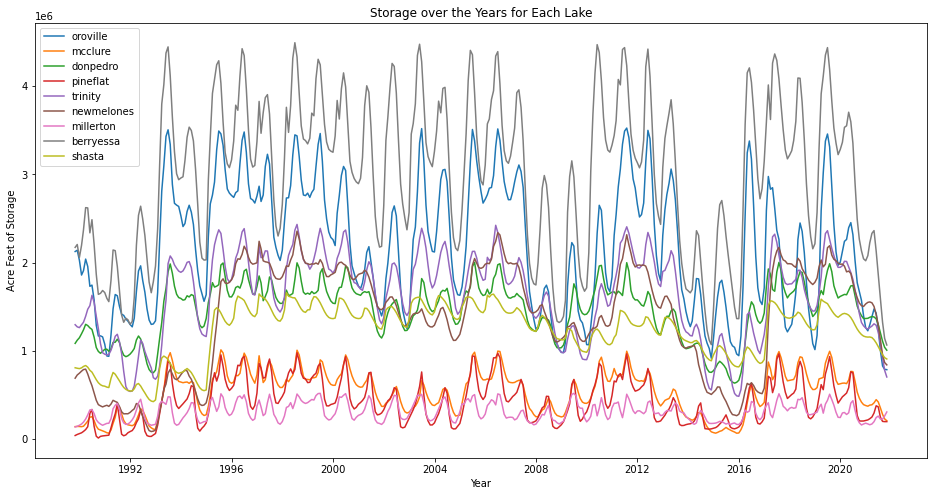

In [14]:
fig, ax = plt.subplots(figsize=(16,8))

for lake in cdec_lake_dfs:
    ax.plot(lake.storage, label = get_lake_name(lake))
    
for lake in rise_lake_dfs:
    ax.plot(lake.storage, label = get_lake_name(lake))
    
plt.title('Storage over the Years for Each Lake')
plt.xlabel('Year')
plt.ylabel('Acre Feet of Storage')
plt.legend()
plt.show();

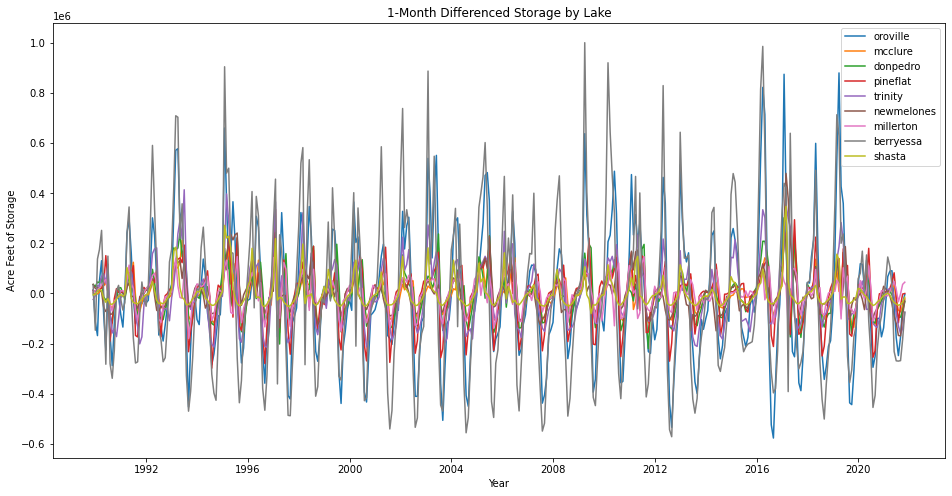

In [15]:
fig, ax = plt.subplots(figsize=(16,8))

for lake in cdec_lake_dfs:
    series = lake.squeeze()
    ax.plot(series.diff(), label = get_lake_name(lake))

for lake in rise_lake_dfs:
    series = lake.squeeze()
    ax.plot(series.diff(), label = get_lake_name(lake))
    
plt.title('1-Month Differenced Storage by Lake')
plt.xlabel('Year')
plt.ylabel('Acre Feet of Storage')
plt.legend()
plt.show();

Above in the graphs, we can see the clear seasonality of all the lake levels.

## Model Preparation
We can automate the process of examining all these by creating functions to build the train and test sets for each, gridsearch a SARIMA fit, and then test these.

In [17]:
def lake_train_test_split(lake):
    train = lake[:-25]
    test = lake[-25:-13]
    return(train,test)

def best_fit_sarima(train):
    model = SARIMAX(endog= train,order=(3,0,3),seasonal_order=(3,0,0,12),enforce_invertibility=False,initialization='approximate_diffuse').fit()
    init_aic = model.aic
    
    gs_model = auto_arima(train,start_p=0,start_d=0,start_q=0,
          max_p=3,max_d=3,max_q=3, start_P=0,start_D=0,
          start_Q=0, max_P=3,max_D=3,
          max_Q=3, m=12, seasonal=True, max_order=10,
          error_action='warn',trace=False,
          supress_warnings=True,stepwise=True,
          random_state=20)
    
    if gs_model.aic() > init_aic:
        print('Selected grid-searched model:', gs_model.summary())
        return(gs_model)
    elif init_aic > gs_model.aic():
        print('Same fit model as Folsom:', model.summary())
        return(model)
    
def test_sarima(model):
    preds = model.get_forecast(steps=12).summary_frame()['mean']
    rmse = np.sqrt(mean_squared_error(preds,test.storage)).round(2) 
    mae = mean_absolute_error(preds,test.storage).round(2)
    cc = np.corrcoef(x=preds,y=test.storage)[0][1].round(4)
    print('RMSE: ', rmse, ' ; MAE', mae, ' ; Correlation Coefficient : ', cc)
    print('Mean error from actual storage level: ', (mae/np.mean(preds))*100, '%')
    return(preds)
    
def plot_preds(preds,df):
    fig,ax = plt.subplots(figsize=(16,8))
    ax.plot(train, color = 'blue',label= 'Historical storage')
    ax.plot(test.storage,color='black',label= 'Actual Water Year storage')
    ax.plot(preds,color= 'orange', label= 'Predicted Water Year Storage')
    plt.legend()
    plt.xlabel('Year')
    plt.ylabel('Acre-feet')
    name = get_lake_name(df)
    plt.title(label = ('Predicted vs. Actual Monthly Mean Storage at ' + name))
    plt.show();
    

## Northern Sierra / Sacramento Watershed Reservoirs

### Lake Oroville

Lake Oroville, located in the foothills below the Northern Sierras, is the second largest reservoir in California and is a key water supply for billions for dollar of agriculture and millions of residents. Oroville is unique in our data in that there is only data from a special consultation which ended in 2003. So our trainset will run from the 1990 to 2002 water seasons. The data is also already aggregated up monthly.

In [18]:
train, test = lake_train_test_split(oroville)
print(train)
print(test)
model = best_fit_sarima(train)





               storage
date                  
1989-10-31  2125937.39
1989-11-30  2140211.90
1989-12-31  2027506.90
1990-01-31  1859354.16
1990-02-28  1909140.46
...                ...
2019-05-31  3376585.39
2019-06-30  3456914.57
2019-07-31  3311089.65
2019-08-31  2874631.94
2019-09-30  2431095.70

[360 rows x 1 columns]
               storage
date                  
2019-10-31  2121942.39
2019-11-30  1970801.73
2019-12-31  2005572.10
2020-01-31  2124443.81
2020-02-29  2241078.24
2020-03-31  2262968.06
2020-04-30  2395626.70
2020-05-31  2452956.55
2020-06-30  2317121.80
2020-07-31  2022535.68
2020-08-31  1772344.71
2020-09-30  1672562.13


/Users/jadeadams/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Same fit model as Folsom:                                       SARIMAX Results                                      
Dep. Variable:                             storage   No. Observations:                  360
Model:             SARIMAX(3, 0, 3)x(3, 0, [], 12)   Log Likelihood            -2264640.359
Date:                             Thu, 09 Dec 2021   AIC                        4529300.717
Time:                                     01:17:52   BIC                        4529339.578
Sample:                                 10-31-1989   HQIC                       4529316.169
                                      - 09-30-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0081      1.447      0.697      0.486      -1.827       3.844
a

RMSE:  528873.52  ; MAE 429859.51  ; Correlation Coefficient :  0.7168
Mean error from actual storage level:  16.97120247675678 %


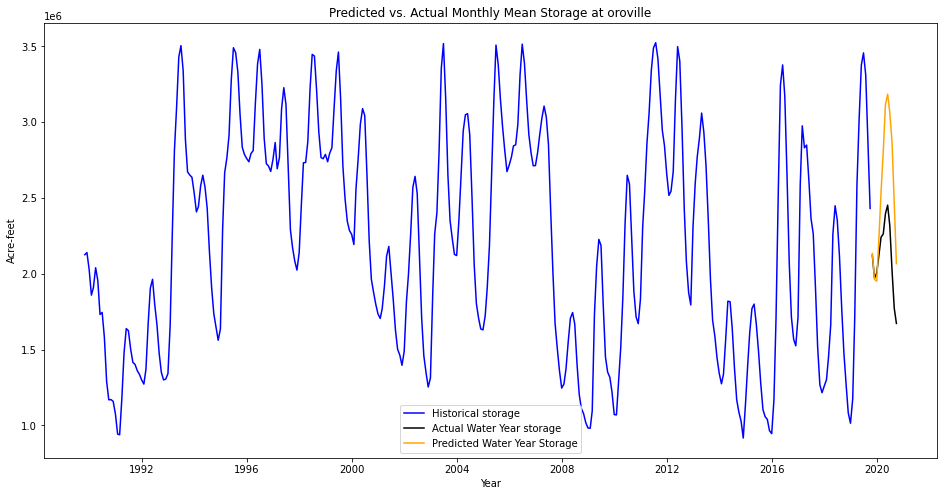

In [19]:
preds = test_sarima(model)

plot_preds(preds,oroville)

From the prediction, we can see that the model didnt predict as big of a decline as Oroville actually experienced; however, it still did good at tracking the ebb and flow of the reservoir.

### Trinity Lake

Trinity, located in the Northern Sierras, is the 3rd largest lake in California.

Same fit model as Folsom:                                       SARIMAX Results                                      
Dep. Variable:                             storage   No. Observations:                  360
Model:             SARIMAX(3, 0, 3)x(3, 0, [], 12)   Log Likelihood             -845444.457
Date:                             Thu, 09 Dec 2021   AIC                        1690908.915
Time:                                     01:22:25   BIC                        1690947.776
Sample:                                 10-31-1989   HQIC                       1690924.367
                                      - 09-30-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0068      0.122      8.244      0.000       0.767       1.246
a

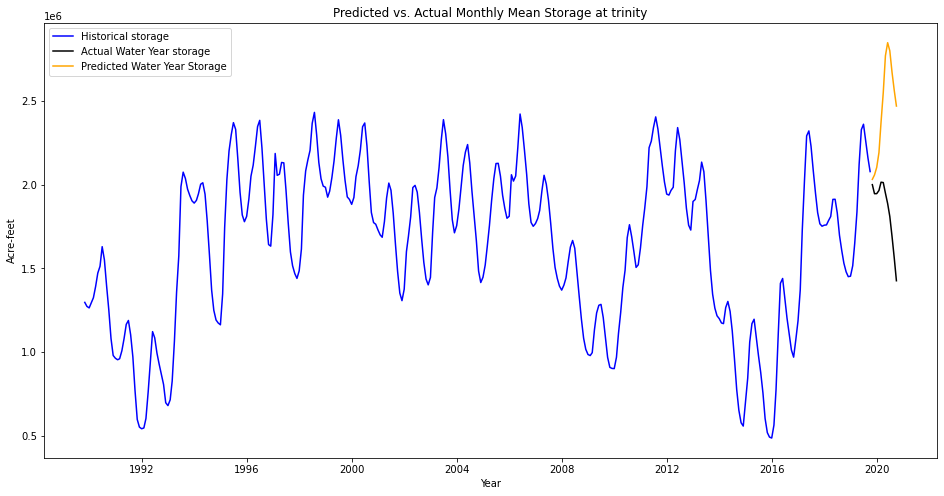

In [20]:
train, test = lake_train_test_split(trinity)

model = best_fit_sarima(train)

preds = test_sarima(model)

plot_preds(preds,trinity)



The prediction was well off and above the actual capacity for the lake. In future work, I will seek to incorporate a maximizing paramater and maybe include preprocessing the storage levels to be on a scale of 0 to 1, 0 being empty and 1 being full. This prediction was also the only one with a negative correlation value, indicating that the model was not a good fit.

### Lake Berryessa

Berryessa, located in the west of California in the California Coastal Ranges, may prove to be different as it is does not collect Sierras water like the rest of the reservoirs.

/Users/jadeadams/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/jadeadams/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/jadeadams/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Same fit model as Folsom:                                       SARIMAX Results                                      
Dep. Variable:                             storage   No. Observations:                  360
Model:             SARIMAX(3, 0, 3)x(3, 0, [], 12)   Log Likelihood            -2364807.869
Date:                             Thu, 09 Dec 2021   AIC                        4729635.738
Time:                                     01:23:00   BIC                        4729674.599
Sample:                                 10-31-1989   HQIC                       4729651.190
                                      - 09-30-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3862      0.023     60.132      0.000       1.341       1.431
a

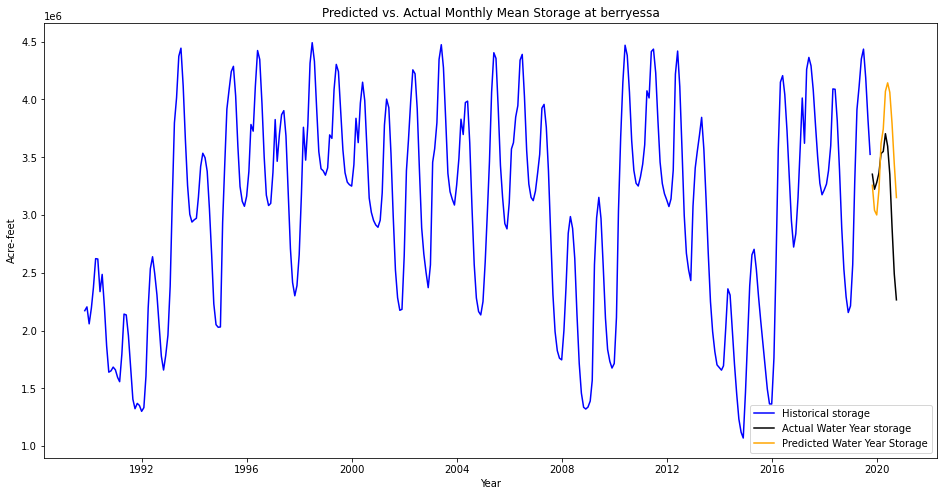

In [21]:
train, test = lake_train_test_split(berryessa)

model = best_fit_sarima(train)

preds = test_sarima(model)

plot_preds(preds,berryessa)



### Shasta Lake

/Users/jadeadams/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/jadeadams/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/jadeadams/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Same fit model as Folsom:                                       SARIMAX Results                                      
Dep. Variable:                             storage   No. Observations:                  360
Model:             SARIMAX(3, 0, 3)x(3, 0, [], 12)   Log Likelihood             -331755.606
Date:                             Thu, 09 Dec 2021   AIC                         663531.213
Time:                                     01:23:46   BIC                         663570.074
Sample:                                 10-31-1989   HQIC                        663546.665
                                      - 09-30-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9639      0.033     29.645      0.000       0.900       1.028
a

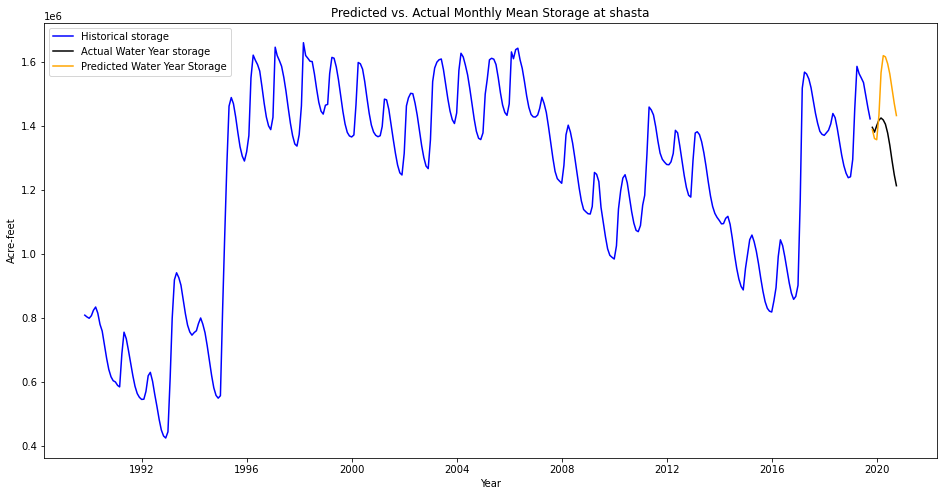

In [22]:
train, test = lake_train_test_split(shasta)
model = best_fit_sarima(train)

preds = test_sarima(model)

plot_preds(preds,shasta)



## San Joaquin Watershed Reservoirs


### Don Pedro

/Users/jadeadams/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/jadeadams/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/jadeadams/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jadeadams/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(2,0,1)(2,0,0)[12] intercept (if you do not

Same fit model as Folsom:                                       SARIMAX Results                                      
Dep. Variable:                             storage   No. Observations:                  360
Model:             SARIMAX(3, 0, 3)x(3, 0, [], 12)   Log Likelihood             -593641.150
Date:                             Thu, 09 Dec 2021   AIC                        1187302.300
Time:                                     01:26:19   BIC                        1187341.161
Sample:                                 10-31-1989   HQIC                       1187317.752
                                      - 09-30-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0228      0.036     28.770      0.000       0.953       1.092
a

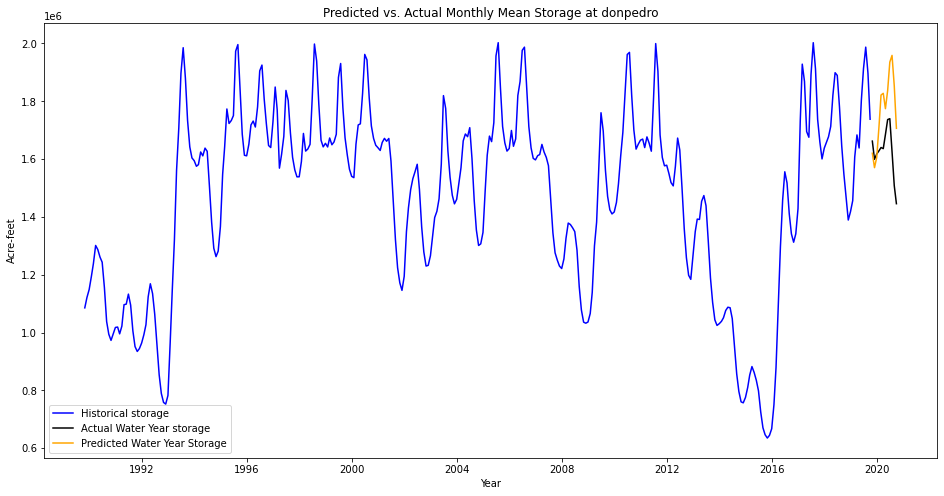

In [23]:
train, test = lake_train_test_split(donpedro)
model = best_fit_sarima(train)

preds = test_sarima(model)

plot_preds(preds,donpedro)


### Lake Mcclure

/Users/jadeadams/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/jadeadams/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jadeadams/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pmdarima/arima/_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(1,0,0)(2,0,0)[12] intercept (if you do not want to see these warnings, run with error_action="ignore").
  warnings.warn(warning_str, ModelFitWarning)


Same fit model as Folsom:                                       SARIMAX Results                                      
Dep. Variable:                             storage   No. Observations:                  360
Model:             SARIMAX(3, 0, 3)x(3, 0, [], 12)   Log Likelihood              -14554.121
Date:                             Thu, 09 Dec 2021   AIC                          29128.241
Time:                                     01:27:44   BIC                          29167.102
Sample:                                 10-31-1989   HQIC                         29143.693
                                      - 09-30-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8726      0.077     11.265      0.000       0.721       1.024
a

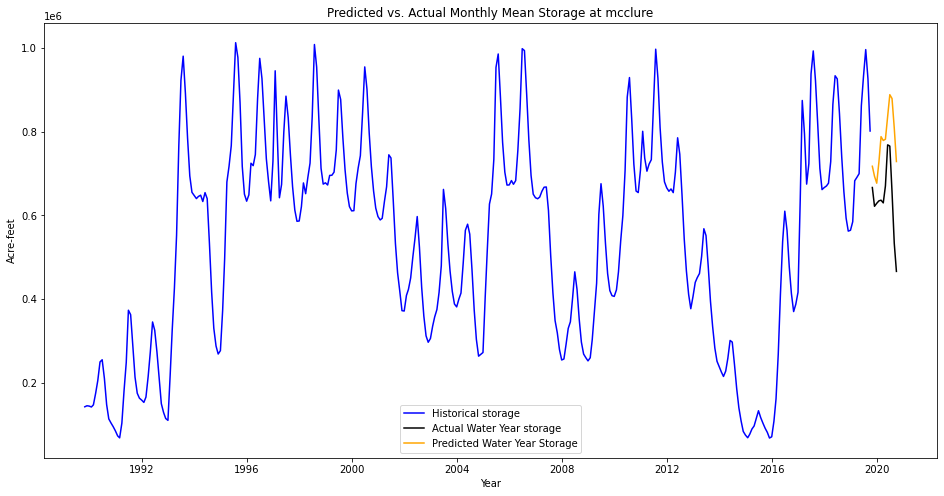

In [24]:
train, test = lake_train_test_split(mcclure)
model = best_fit_sarima(train)

preds = test_sarima(model)

plot_preds(preds,mcclure)

### New Melones

Same fit model as Folsom:                                       SARIMAX Results                                      
Dep. Variable:                             storage   No. Observations:                  360
Model:             SARIMAX(3, 0, 3)x(3, 0, [], 12)   Log Likelihood             -243170.539
Date:                             Thu, 09 Dec 2021   AIC                         486361.078
Time:                                     01:28:06   BIC                         486399.939
Sample:                                 10-31-1989   HQIC                        486376.530
                                      - 09-30-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1533      0.054     21.410      0.000       1.048       1.259
a

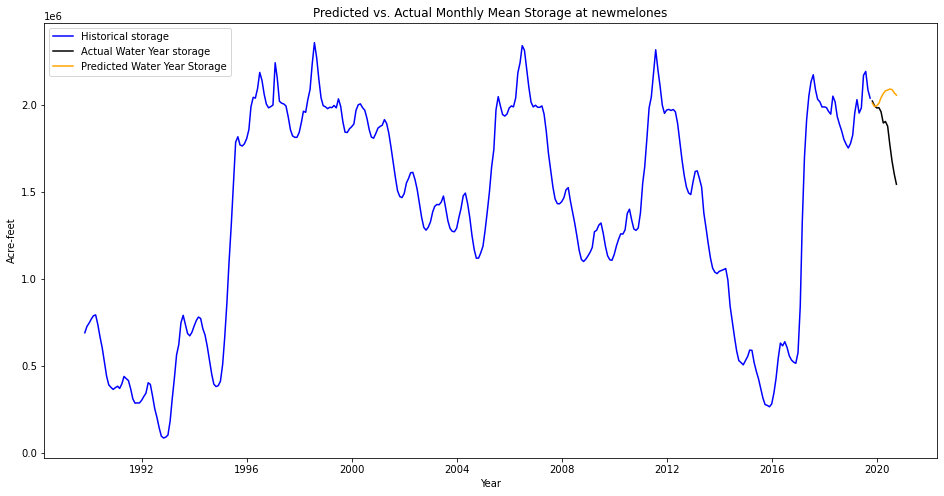

In [25]:
train, test = lake_train_test_split(newmelones)
model = best_fit_sarima(train)

preds = test_sarima(model)

plot_preds(preds,newmelones)



### Pine Flat

/Users/jadeadams/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/jadeadams/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Same fit model as Folsom:                                       SARIMAX Results                                      
Dep. Variable:                             storage   No. Observations:                  360
Model:             SARIMAX(3, 0, 3)x(3, 0, [], 12)   Log Likelihood               -5397.998
Date:                             Thu, 09 Dec 2021   AIC                          10815.996
Time:                                     01:30:05   BIC                          10854.857
Sample:                                 10-31-1989   HQIC                         10831.448
                                      - 09-30-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6564      0.688      2.407      0.016       0.308       3.005
a

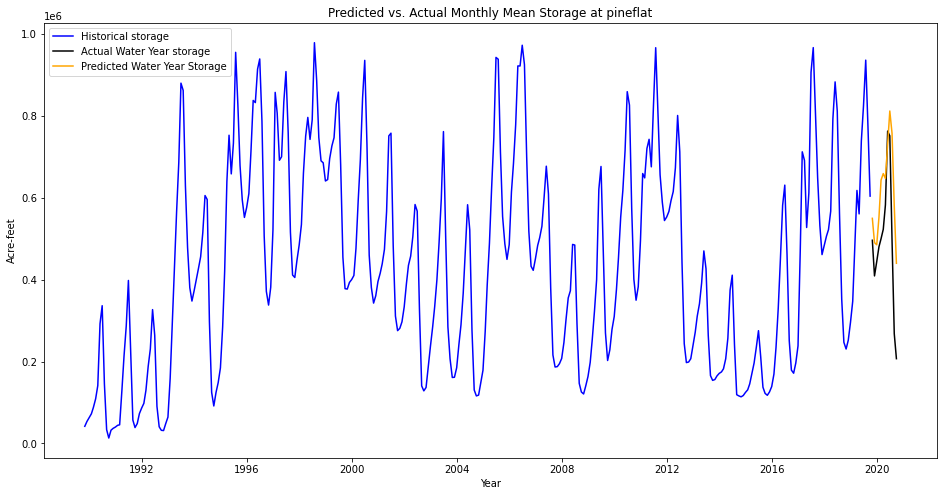

In [26]:
train, test = lake_train_test_split(pineflat)
model = best_fit_sarima(train)

preds = test_sarima(model)

plot_preds(preds,pineflat)


### Millerton

/Users/jadeadams/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/jadeadams/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Same fit model as Folsom:                                       SARIMAX Results                                      
Dep. Variable:                             storage   No. Observations:                  360
Model:             SARIMAX(3, 0, 3)x(3, 0, [], 12)   Log Likelihood              -14013.184
Date:                             Thu, 09 Dec 2021   AIC                          28046.368
Time:                                     01:33:28   BIC                          28085.229
Sample:                                 10-31-1989   HQIC                         28061.820
                                      - 09-30-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2335      0.329      3.751      0.000       0.589       1.878
a

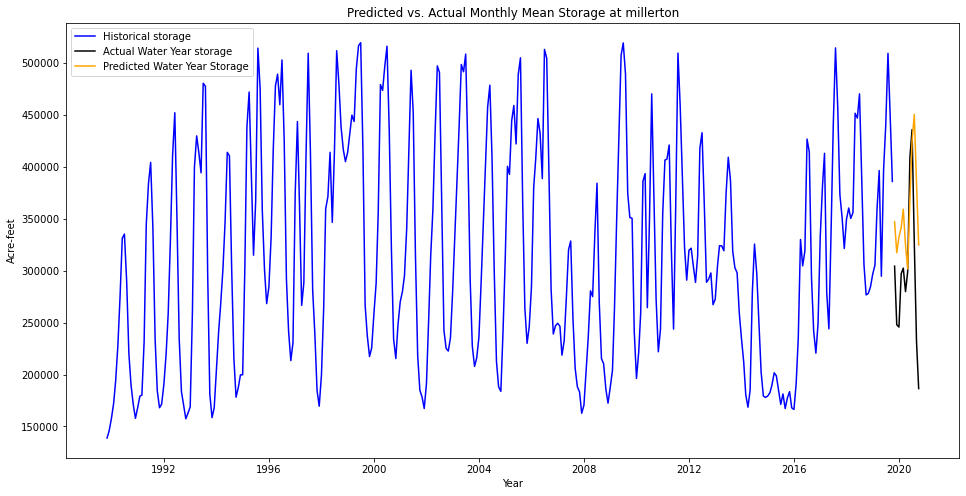

In [27]:
train, test = lake_train_test_split(millerton)
model = best_fit_sarima(train)

preds = test_sarima(model)

plot_preds(preds,millerton)

# Recommendations

Above, we can see the strength of machine learning in a predicting the ebb and flow and the general accuracy of reservoirs. However; in significant drought years like 2021, the model will struggle to predict out-of-average rainfall. Overall, we can see a promising future in machine learning and neural networks as they can detect many things a brute-force equation (like water year indexing- see my slides) cannot.

The strengths in the auto-regressive model lie in its ability to detect the cycles of drought and provide a solid mean prediction in most cases of what the next year can look like. With many different things impacting reservoir levels, it makes sense than that the SARIMA model with a high number of paramaters (9 in total) was consistently better in prediction than underfitted ones.

# Future Work

1. Model inflow as an endogenous variable: The most important way to predict reservoir storage is by knowing how much inflow is coming in. I seek to develop a seasonal model of inflows for reservoirs and see how well auto-regressive and exogenous paramaters can predict inflow.

2. Incorporate reservoir operations understanding: Reservoir outflows are carefully managed by engineers depending on the water conditions and anticipation of future inflows. The auto-regressive model has some capability of picking up this, but with more hashed out paramaters there can be better predictions.

3. Try advanced exogenous variables inclusion and stagger predictions with updates based on new information: As the water year is indexed 6 months into the season in May, one is able to predict more accurately how the reservoir conditions will look. If we can incorporate such data into the auto-regressive model, it will have a clear outcome.

4. More data-pre-processing: Some model years, like Lake Trinity above, were significantly off as they went above and beyond the actual possible low. Similarly, the model is weak as with each reservoir and year it consistently estimated higher reservoir levels than the actual water year. This overestimation could be solved through normalization.

# References

1. https://escholarship.org/uc/item/6hq949t6
2. https://data.usbr.gov/time-series/search?v=1
3. https://www.usgs.gov/special-topic/water-science-school/science/droughts-things-know?qt-science_center_objects=0#qt-science_center_objects
4. https://towardsdatascience.com/efficient-time-series-using-pythons-pmdarima-library-f6825407b7f0
5. https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/
6. https://machinelearningmastery.com/how-to-grid-search-sarima-model-hyperparameters-for-time-series-forecasting-in-python/